In [72]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder,StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.api import qqplot
from statsmodels import api
from statsmodels.graphics.regressionplots import influence_plot
from pickle import dump

## 1.Loding Data

In [33]:
data = pd.read_csv('Datasets/50_Startups.csv')
data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


## 2.Data Analysis

In [3]:
data.shape

(50, 5)

In [4]:
data.dtypes

R&D Spend          float64
Administration     float64
Marketing Spend    float64
State               object
Profit             float64
dtype: object

In [5]:
data.isna().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

## 3.data Preprocessing

In [34]:
data.columns

Index(['R&D Spend', 'Administration', 'Marketing Spend', 'State', 'Profit'], dtype='object')

In [35]:
data = data.rename({'R&D Spend':'RD','Administration':'Admin',
                     'Marketing Spend':'Mrkt','State':'State','Profit':'Profit'},axis=1)

In [59]:
data.columns

Index(['RD', 'Admin', 'Mrkt', 'State', 'Profit'], dtype='object')

In [60]:
data.State.unique()

array(['New York', 'California', 'Florida'], dtype=object)

In [36]:
#lets apply label encoding for state feature
lbl_encode = LabelEncoder()
data['State'] = lbl_encode.fit_transform(data['State'])
print(data['State'].unique())


[2 0 1]


**Standardizing data**

In [40]:
std_sclr = StandardScaler()

tem_data = data.drop(labels=('Profit'),axis=1)
col_names = tem_data.columns
tem_data = std_sclr.fit_transform(tem_data)
tem_data = pd.DataFrame(data=tem_data,columns=col_names)
data['RD'] = tem_data['RD']
data['Admin'] = tem_data['Admin']
data['Mrkt'] = tem_data['Mrkt']
data.isna().sum()

RD        0
Admin     0
Mrkt      0
State     0
Profit    0
dtype: int64

## 4.Assumption check
### 4.1 Linearity check

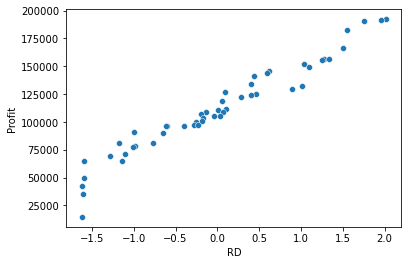

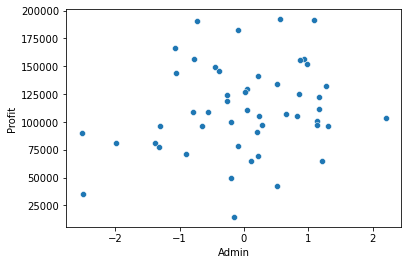

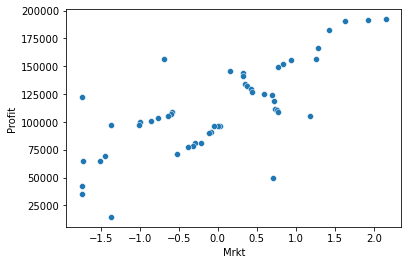

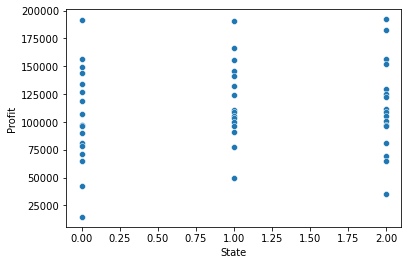

In [44]:

x = np.linspace( 0,10 )

for i in data.columns:
    if i != 'Profit':
        plt.figure()
        sns.scatterplot(x=data[i],y=y['Profit'])   
plt.show()
#not all features are linearly related to response

## 4.2. Multicolinearity check

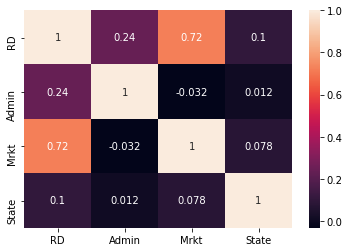

In [47]:
sns.heatmap(data.iloc[:,0:4].corr(),annot=True)
plt.show()

#the predictors 'Marketing Spend' and 'R&D Spend' seems to be 72% positively corelated
#which may not be good for a linear model

In [48]:
#calculating VIF of each independent variables against all other independent variable
#variance inflation factor

def cal_VIF(X):
    
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    
    return vif

##calling cal_VIF function with using only the predictor
# using original data fro VIF calculation
print(cal_VIF(data.iloc[:,0:4]))

#all the VIF values are <5 which is acceptable

  variables       VIF
0        RD  2.473838
1     Admin  1.175181
2      Mrkt  2.326776
3     State  1.004536


## 5. selecting best feature combination for our linear regression

In [49]:
x = 0
input_var = ''
for i in data.columns:
    if i != 'Profit':
        if x == 0:
            input_var = input_var+i
        else:
            input_var = input_var+'+'+i
            
        model_1 = ols('Profit~'+input_var,data).fit()
        print(input_var + ' Model')
        print('Pvalue       : ', model_1.pvalues[1])
        print('r squared    :',model_1.rsquared)
        print('adj r squared:',model_1.rsquared_adj)
        print('aic          :',model_1.aic)
        print('bic          :',model_1.bic)
        print('*************************************************')
        x = x+1

RD Model
Pvalue       :  3.5003222436900994e-32
r squared    : 0.9465353160804393
adj r squared: 0.9454214684987817
aic          : 1058.8730295624773
bic          : 1062.6970755733337
*************************************************
RD+Admin Model
Pvalue       :  2.278348154643724e-31
r squared    : 0.9478129385009172
adj r squared: 0.9455922124796796
aic          : 1059.6636934567296
bic          : 1065.399762473014
*************************************************
RD+Admin+Mrkt Model
Pvalue       :  2.634967721470446e-22
r squared    : 0.9507459940683246
adj r squared: 0.9475337762901719
aic          : 1058.7714985998055
bic          : 1066.419590621518
*************************************************
RD+Admin+Mrkt+State Model
Pvalue       :  8.249206220499037e-22
r squared    : 0.9507462044842656
adj r squared: 0.9463680893273114
aic          : 1060.7712849964787
bic          : 1070.3314000236194
*************************************************


**conclusion, model with predictors RD_Spend+Administration+Marketing_Spend and with RD_Spend+Administration+Marketing_Spend+State have almost the same ,adding State is not making much difference
so lets not include State in our model**

In [50]:
data.drop(labels=('State'),axis=1,inplace=True)
data.head()

,RD,Admin,Mrkt,Profit
0,2.016411,0.560753,2.153943,192261.83
1,1.955860,1.082807,1.923600,191792.06
2,1.754364,-0.728257,1.626528,191050.39
3,1.554784,-0.096365,1.422210,182901.99
4,1.504937,-1.079919,1.281528,166187.94


In [51]:
train_data = data.iloc[:40,:]
test_data = data.iloc[40:,:]

### lets check if there are any outliers

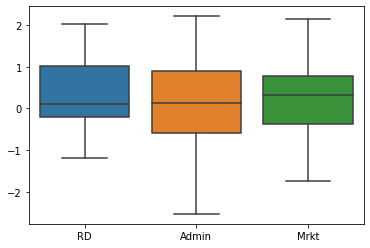

In [56]:
sns.boxplot(data=train_data.iloc[:,0:3])
plt.show()

**there are no outliers in data and the distribution is pretty normal**

## 6.Model building and TRaining

In [57]:
profit_pred_model1 = ols(formula='Profit~RD+Admin+Mrkt',data=train_data).fit()

## 7.Model testing and Evaluation using Train data

In [58]:
y_train_pred = profit_pred_model1.predict(train_data)

In [73]:
metrics.mean_absolute_error(train_data['Profit'],y_train_pred)

5924.087299021136

## 8. Assumption check

### 8.1 Residual Normality Check

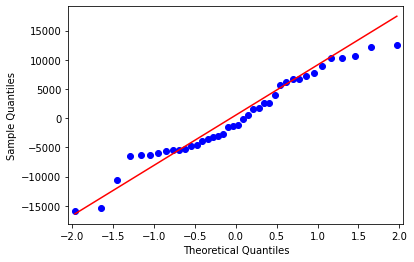

In [60]:
pl = qqplot(profit_pred_model1.resid,line='q')

### 8.2 Homoscedasticity check

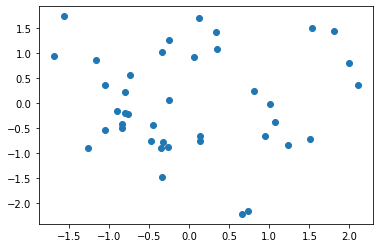

In [61]:
def get_standardized_values( vals ):
    return (vals - vals.mean())/vals.std()

plt.scatter(get_standardized_values(profit_pred_model1.fittedvalues),
            get_standardized_values(profit_pred_model1.resid))
plt.show()

## 9.Model testing and evaluation using test data

In [62]:
y_test_pred = profit_pred_model1.predict(test_data)

In [63]:
metrics.mean_absolute_error(test_data['Profit'],y_test_pred)

10170.91419666863

### Regression vs Regressor

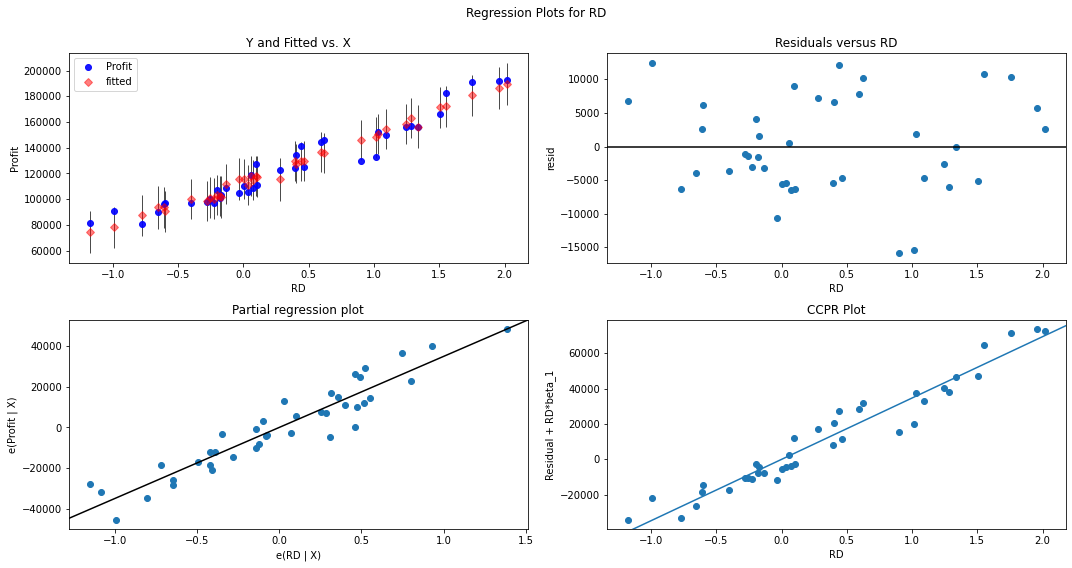

In [64]:
# Regression vs 'RD'
#enog is y
#exog is x
fig = plt.figure(figsize=(15,8))
fig = api.graphics.plot_regress_exog(profit_pred_model1,'RD',fig=fig)
plt.show()

#plot1 is exog vs edog, i.e RD vs Profit which should be linear
#plot2 is exog vs residuals, which should be with equal variance
#plot3 is exog vs fitted or predicted values
#plot4 is exog vs fitted values plus residuals

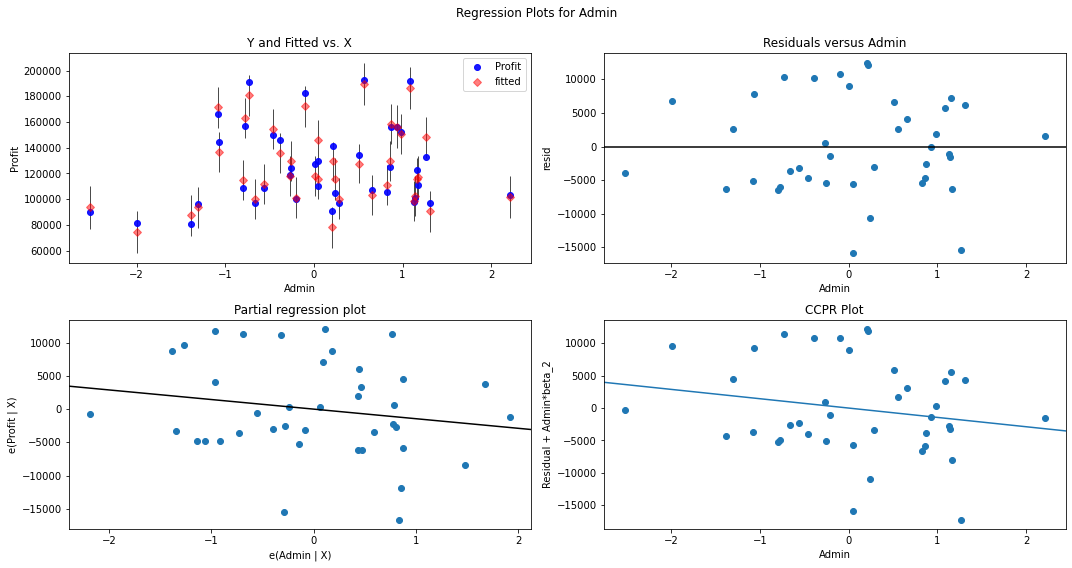

In [141]:
# Regression vs 'Admin'
#enog is y
#exog is x
fig = plt.figure(figsize=(15,8))
fig = api.graphics.plot_regress_exog(profit_pred_model1,'Admin',fig=fig)
plt.show()

#plot1 is exog vs edog, i.e Admin vs Profit which should be linear
#plot2 is exog vs residuals, which should be with equal variance
#plot3 is exog vs fitted or predicted values
#plot4 is exog vs fitted values plus residuals

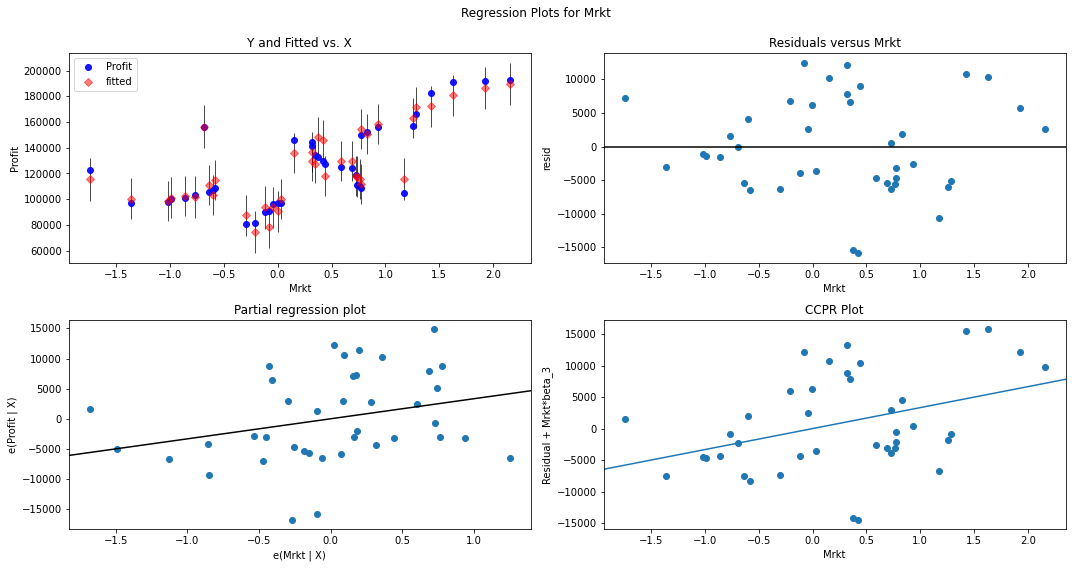

In [65]:
# Regression vs 'Mrkt'
#enog is y
#exog is x
fig = plt.figure(figsize=(15,8))
fig = api.graphics.plot_regress_exog(profit_pred_model1,'Mrkt',fig=fig)
plt.show()

#plot1 is exog vs edog, i.e Mrkt vs Profit which should be linear
#plot2 is exog vs residuals, which should be with equal variance
#plot3 is exog vs fitted or predicted values
#plot4 is exog vs fitted values plus residuals

### Model improvement

In [66]:
## using cooks distance to dine most influencing data points
model = ols(formula='Profit~RD+Admin+Mrkt',data=data).fit()
model_influence1 = model.get_influence()
(c,_) = model_influence1.cooks_distance

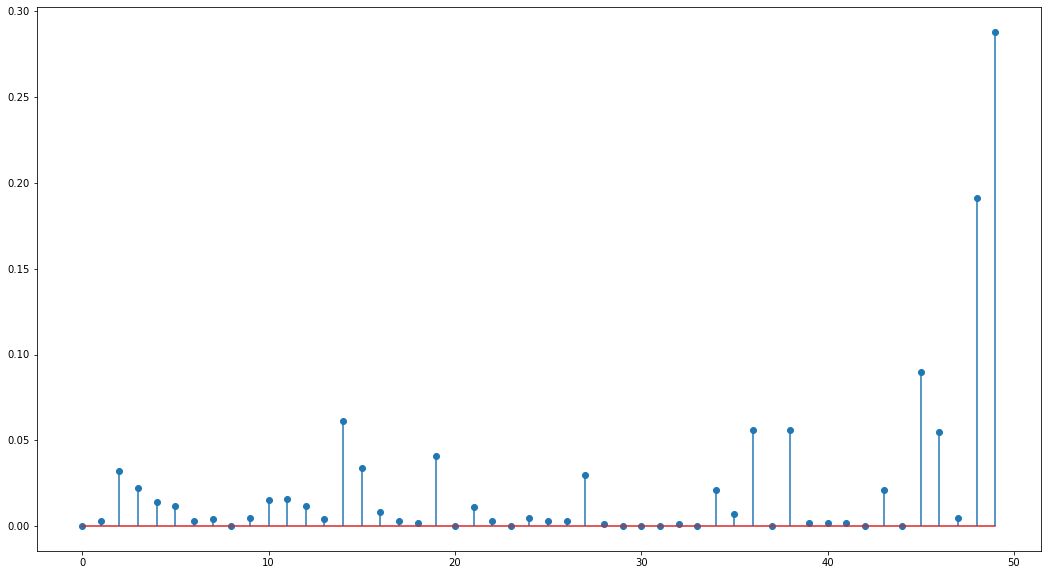

In [67]:
#ploting stem plot using cooks distance

plt.figure(figsize=(18,10))
plt.stem(np.arange(len(data)),np.round(c,3))
plt.show()

In [68]:
#find the poitn with highest cooks distance 
(np.argmax(c),np.max(c))

(49, 0.2880822927543267)

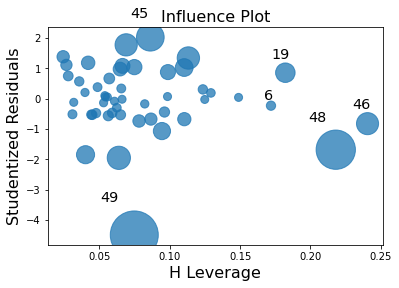

In [69]:
#same inference can be drawn using influence plot

influence_plot(model)
plt.show()

In [70]:
#calculate leverage cut off= 3*((col+1)/rows)

c = data.shape[1]
r = data.shape[0]
cutoff = 3*((c+1)/r)
cutoff

#so all the data points above cutoff are infulencial. points ..

0.30000000000000004

## there are no high influence data points in this data

## Model deployment

In [71]:
dump(profit_pred_model1,open('Profit_pred.pkl','wb'))